# Visualize colocalized intron
- need to cite, see repository
- https://github.com/jackhump/sqtlviztools
- some functions are not properly implemented in package (?), see https://github.com/jackhump/sqtlviztools/blob/10994f405b04bed80e06839bd669e40a8d2a2b48/R/sQTL_functions.R for function code
- for other example loci, probably easier just create the required files manually, check formats here, see last save RData command for what files are needed

**Shiny**
- `run_shiny.R` needs to be in the same folder as `server.R` and `ui.R`, see function `shiny::runApp`
- need to launch browser, download to local
- in terminal, `Rscript run_shiny.R ../results.RData`
- also had to downgrade to shiny v1.6.0, 1.7 gives error. See https://github.com/rstudio/shiny/issues/3556

**prepare input data**
- `plink --vcf filtered.hg19.sorted.removeRel.vcf.gz --extract ~/project-gandalm/isoform_twas/colocal/sqtlviztools/variants.txt --keep-allele-order --recode vcf --out ~/project-gandalm/isoform_twas/colocal/sqtlviztools/variants` remove headers
- from `leafcutter_perind_numers.counts.gz` extract colocalized cluster
- from `sig_pheno_gene_info.txt` extract the introns, all permutation significant, to use as `sigJunctions` in script

In [1]:
library(dplyr)
library(purrr)
library(data.table)
library(leafviz)
library(stringr)
library(readr)
library(sqtlviztools)

library(ggplot2)

Warning message:
“replacing previous import ‘lifecycle::last_warnings’ by ‘rlang::last_warnings’ when loading ‘tibble’”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following object is masked from ‘package:purrr’:

    transpose


The following objects are masked from ‘package:dplyr’:

    between, first, last


Warning message:
“replacing previous import ‘lifecycle::last_warnings’ by ‘rlang::last_warnings’ when loading ‘hms’”

Attaching package: ‘sqtlviztools’


The following object is masked from ‘package:leafviz’:

    make_gene_plot




In [2]:
setwd("../sqtlviztools/")

In [3]:
VCF <- "variants.vcf"
clusters_table <- "clu_100938_NA_cluster_counts.txt"

In [4]:
clusters <- read.table(clusters_table, header = TRUE, stringsAsFactors = FALSE, check.names = FALSE)

In [5]:
rownames(clusters) <- clusters$V1
clusters <- clusters[,-1]

In [6]:
vcf <- read.table(file =  VCF, header = TRUE, check.names = FALSE)

**rs2282889 is colocalized, but not in permutation primary eQTL results. According to the prepare_example.R code, only primary QTL is to be plotted (significant or not)**

In [7]:
vcf_meta <- sqtlviztools::get_vcf_meta(vcf)
vcf_meta

SNP,SNP_pos,REF,ALT
<chr>,<chr>,<chr>,<chr>
rs2282889,:,A,G
rs10276352,:,G,A


In [8]:
vcf_meta$SNP_pos[1] <- "7:21476188"
vcf_meta$SNP_pos[2] <- "7:21521233"

In [9]:
sigClusters <- "clu_100938_NA"

In [10]:
introns <- leafviz::get_intron_meta(row.names(clusters) )
keepClusters <- match(introns$clu,sigClusters)

In [11]:
introns
keepClusters

chr,start,end,clu,middle
<chr>,<dbl>,<dbl>,<chr>,<dbl>
chr7,21516925,21521120,clu_100938_NA,21519022
chr7,21516925,21521542,clu_100938_NA,21519234
chr7,21521300,21521542,clu_100938_NA,21521421


[1] 1 1 1

In [12]:
samples <- names(vcf)[10:ncol(vcf)]
bam_samples <- names(clusters)

In [13]:
which(bam_samples == "1707.1.STARAligned.sortedByCoord.WASPfiltered.out.bam")

[1] 191

In [14]:
for (i in 1:length(bam_samples)) {
    bam_samples[i] <- strsplit(bam_samples[i], split = "[.]")[[1]][1]
}

In [15]:
which(bam_samples == "1707")

[1] 191 344

In [16]:
bam_samples[191] <- "1707.1"

In [17]:
names(clusters) <- bam_samples

In [18]:
clusters <- clusters[, samples]

In [17]:
introns_to_plot <- get_intron_meta(row.names(clusters))
introns_to_plot

chr,start,end,clu,middle
<chr>,<dbl>,<dbl>,<chr>,<dbl>
chr7,21516925,21521120,clu_100938_NA,21519022
chr7,21516925,21521542,clu_100938_NA,21519234
chr7,21521300,21521542,clu_100938_NA,21521421


In [18]:
juncProp <- function(cluster){
  cluster$prop <- cluster$meanCount / sum(cluster$meanCount)
  return(cluster)
}

In [19]:
splitClusters <- introns_to_plot %>%
  mutate(
    clu = factor(.$clu, levels = unique(.$clu)),
    meanCount = rowMeans(clusters) ) %>%
  split( .$clu ) %>%
  purrr::map_df( juncProp ) %>%
  mutate( clu = as.character(.$clu))

**The annotated intron is dominant**

In [56]:
splitClusters

chr,start,end,clu,middle,meanCount,prop
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
chr7,21516925,21521120,clu_100938_NA,21519022,1.5562500,0.017948210
chr7,21516925,21521542,clu_100938_NA,21519234,84.4031250,0.973420071
chr7,21521300,21521542,clu_100938_NA,21521421,0.7484375,0.008631719


In [21]:
res <- read.table("perm.res.txt", header = T)

In [64]:
res

pid,nvar,shape1,shape2,dummy,sid,dist,npval,slope,ppval,...,qval,pval_nominal_threshold,verdict,gene,ensemblID,ensg,version,transcripts,constitutive.score,gene_type
<chr>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>
7:21516925:21521542:clu_100938_NA,7767,1.06107,1334.52,519.289,rs10276352,4307,1.15436e-13,0.407386,0.00009999,...,3.00601e-08,8.64826e-06,annotated,SP4,ENSG00000105866.15_5,ENSG00000105866,15_5,ENST00000222584.8_2+ENST00000448246.1_1+ENST00000649633.1_1,1,protein_coding
7:21521300:21521542:clu_100938_NA,7774,1.04961,1358.03,521.742,rs10276352,-68,3.36785e-08,-0.283003,0.00029997,...,1.83283e-03,8.05151e-06,cryptic_fiveprime,SP4,ENSG00000105866.15_5,ENSG00000105866,15_5,.,0,protein_coding
7:21516925:21521120:clu_100938_NA,7767,1.06005,1275.23,514.643,rs10276352,4307,3.13552e-08,-0.306670,0.00019998,...,1.79647e-03,9.00731e-06,cryptic_threeprime,SP4,ENSG00000105866.15_5,ENSG00000105866,15_5,.,0,protein_coding


In [22]:
sigJunctions <- cbind( get_intron_meta(res[,1]),
                       res[, c("pid", "bpval")],
                       get_snp_meta(res[,6]))

# sometimes there will be duplicates - remove!
sigJunctions <- dplyr::distinct(sigJunctions)

In [23]:
sigJunctions

chr,start,end,clu,middle,pid,bpval,snp_ID,snp_chr,snp_pos
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
7,21516925,21521542,clu_100938_NA,21519234,7:21516925:21521542:clu_100938_NA,1.40225e-09,rs10276352,,NA
7,21521300,21521542,clu_100938_NA,21521421,7:21521300:21521542:clu_100938_NA,1.89265e-04,rs10276352,,NA
7,21516925,21521120,clu_100938_NA,21519022,7:21516925:21521120:clu_100938_NA,1.85196e-04,rs10276352,,NA


In [24]:
sigJunctions$snp_chr <- "7"
sigJunctions$snp_pos <- "21521233"

In [25]:
sigJunctions

chr,start,end,clu,middle,pid,bpval,snp_ID,snp_chr,snp_pos
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>
7,21516925,21521542,clu_100938_NA,21519234,7:21516925:21521542:clu_100938_NA,1.40225e-09,rs10276352,7,21521233
7,21521300,21521542,clu_100938_NA,21521421,7:21521300:21521542:clu_100938_NA,1.89265e-04,rs10276352,7,21521233
7,21516925,21521120,clu_100938_NA,21519022,7:21516925:21521120:clu_100938_NA,1.85196e-04,rs10276352,7,21521233


In [26]:
resultsByCluster <- dplyr::group_by(sigJunctions[order(sigJunctions$bpval),], clu) %>%
  dplyr::summarise( chr = first(chr),
                    start = min(start),
                    end = max(end),
                    snp = first(snp_ID),
                    snp_chr = first(snp_chr),
                    pos = first(snp_pos),
                    FDR = first(bpval) ) %>%
  dplyr::arrange(FDR)
resultsByCluster

clu,chr,start,end,snp,snp_chr,pos,FDR
<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
clu_100938_NA,7,21516925,21521542,rs10276352,7,21521233,1.40225e-09


In [27]:
resultsByCluster$gene <- "SP4"
resultsByCluster$SNP_pos <- paste0(resultsByCluster$snp_chr, ":", resultsByCluster$pos)

In [28]:
resultsByCluster$cluster_pos = paste0(resultsByCluster$chr,":", resultsByCluster$start,"-",resultsByCluster$end)

resultsToPlot <- as.data.frame( select( resultsByCluster,
                                        SNP = snp,
                                        SNP_pos,
                                        gene = gene,
                                        cluster_pos,
                                        q = FDR
) )

row.names(resultsToPlot) <- resultsByCluster$clu

resultsToPlot$q <- signif(resultsToPlot$q,  digits = 3)

In [29]:
resultsByCluster

clu,chr,start,end,snp,snp_chr,pos,FDR,gene,SNP_pos,cluster_pos
<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>
clu_100938_NA,7,21516925,21521542,rs10276352,7,21521233,1.40225e-09,SP4,7:21521233,7:21516925-21521542


In [30]:
resultsToPlot

,SNP,SNP_pos,gene,cluster_pos,q
,<chr>,<chr>,<chr>,<chr>,<dbl>
clu_100938_NA,rs10276352,7:21521233,SP4,7:21516925-21521542,1.4e-09


**For this cluster, all 3 introns are permutation significant**

In [81]:
introns_to_plot

chr,start,end,clu,middle
<chr>,<dbl>,<dbl>,<chr>,<dbl>
chr7,21516925,21521120,clu_100938_NA,21519022
chr7,21516925,21521542,clu_100938_NA,21519234
chr7,21521300,21521542,clu_100938_NA,21521421


In [31]:
junctionsNeeded <- introns_to_plot %>%
    mutate( chr = gsub("chr", "", chr)) %>%
    mutate( cluster = paste( chr, start, end, clu, sep = ":") ) %>%
    pull( cluster )

In [32]:
junctionsNeeded

[1] "7:21516925:21521120:clu_100938_NA" "7:21516925:21521542:clu_100938_NA"
[3] "7:21521300:21521542:clu_100938_NA"

In [33]:
junctionTable <- resultsToPlot %>%
  mutate( clu = row.names(resultsToPlot) ) %>%
  left_join(introns_to_plot, by = "clu" ) %>%
  rename(snp_ID = SNP)
junctionTable

snp_ID,SNP_pos,gene,cluster_pos,q,clu,chr,start,end,middle
<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
rs10276352,7:21521233,SP4,7:21516925-21521542,1.4e-09,clu_100938_NA,chr7,21516925,21521120,21519022
rs10276352,7:21521233,SP4,7:21516925-21521542,1.4e-09,clu_100938_NA,chr7,21516925,21521542,21519234
rs10276352,7:21521233,SP4,7:21516925-21521542,1.4e-09,clu_100938_NA,chr7,21521300,21521542,21521421


In [34]:
res <- cbind( res, get_intron_meta(res$pid), get_snp_meta(res$sid) )

In [95]:
res

pid,nvar,shape1,shape2,dummy,sid,dist,npval,slope,ppval,...,constitutive.score,gene_type,chr,start,end,clu,middle,snp_ID,snp_chr,snp_pos
<chr>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,...,<int>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
7:21516925:21521542:clu_100938_NA,7767,1.06107,1334.52,519.289,rs10276352,4307,1.15436e-13,0.407386,0.00009999,...,1,protein_coding,7,21516925,21521542,clu_100938_NA,21519234,rs10276352,,NA
7:21521300:21521542:clu_100938_NA,7774,1.04961,1358.03,521.742,rs10276352,-68,3.36785e-08,-0.283003,0.00029997,...,0,protein_coding,7,21521300,21521542,clu_100938_NA,21521421,rs10276352,,NA
7:21516925:21521120:clu_100938_NA,7767,1.06005,1275.23,514.643,rs10276352,4307,3.13552e-08,-0.306670,0.00019998,...,0,protein_coding,7,21516925,21521120,clu_100938_NA,21519022,rs10276352,,NA


In [35]:
res$snp_chr <- "chr7"
res$snp_pos <- "21521233"

In [36]:
junctionTable <- junctionTable %>%
  left_join( res, by=c("start", "end", "chr" = "snp_chr", "snp_ID" = "sid", "clu", "middle")) %>%
  mutate(coord = paste0( chr, ":", start, "-", end))

In [37]:
junctionTable

snp_ID,SNP_pos,gene.x,cluster_pos,q,clu,chr,start,end,middle,...,ensemblID,ensg,version,transcripts,constitutive.score,gene_type,chr.y,snp_ID.y,snp_pos,coord
<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,...,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
rs10276352,7:21521233,SP4,7:21516925-21521542,1.4e-09,clu_100938_NA,chr7,21516925,21521120,21519022,...,ENSG00000105866.15_5,ENSG00000105866,15_5,.,0,protein_coding,7,rs10276352,21521233,chr7:21516925-21521120
rs10276352,7:21521233,SP4,7:21516925-21521542,1.4e-09,clu_100938_NA,chr7,21516925,21521542,21519234,...,ENSG00000105866.15_5,ENSG00000105866,15_5,ENST00000222584.8_2+ENST00000448246.1_1+ENST00000649633.1_1,1,protein_coding,7,rs10276352,21521233,chr7:21516925-21521542
rs10276352,7:21521233,SP4,7:21516925-21521542,1.4e-09,clu_100938_NA,chr7,21521300,21521542,21521421,...,ENSG00000105866.15_5,ENSG00000105866,15_5,.,0,protein_coding,7,rs10276352,21521233,chr7:21521300-21521542


In [100]:
colnames(junctionTable)

[1] "snp_ID"                 "SNP_pos"                "gene.x"                
 [4] "cluster_pos"            "q"                      "clu"                   
 [7] "chr"                    "start"                  "end"                   
[10] "middle"                 "pid"                    "nvar"                  
[13] "shape1"                 "shape2"                 "dummy"                 
[16] "dist"                   "npval"                  "slope"                 
[19] "ppval"                  "bpval"                  "qval"                  
[22] "pval_nominal_threshold" "verdict"                "gene.y"                
[25] "ensemblID"              "ensg"                   "version"               
[28] "transcripts"            "constitutive.score"     "gene_type"             
[31] "chr.y"                  "snp_ID.y"               "snp_pos"               
[34] "coord"

**TODO Make sure "Beta" is slope, "q" is "FDR" is bpval**

In [38]:
junctionTable <- junctionTable %>% select(clu, coord, verdict, Beta = slope, q = bpval) %>%
  mutate( Beta = signif(Beta, digits = 3),
          q = signif(q, digits = 3)) %>%
  mutate( Beta = ifelse(is.na(Beta), ".", Beta),
          q = ifelse(is.na(q), ".", q))

In [39]:
junctionTable

clu,coord,verdict,Beta,q
<chr>,<chr>,<chr>,<dbl>,<dbl>
clu_100938_NA,chr7:21516925-21521120,cryptic_threeprime,-0.307,1.85e-04
clu_100938_NA,chr7:21516925-21521542,annotated,0.407,1.40e-09
clu_100938_NA,chr7:21521300-21521542,cryptic_fiveprime,-0.283,1.89e-04


In [103]:
sigJunctions

chr,start,end,clu,middle,pid,bpval,snp_ID,snp_chr,snp_pos
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>
7,21516925,21521542,clu_100938_NA,21519234,7:21516925:21521542:clu_100938_NA,1.40225e-09,rs10276352,7,21521233
7,21521300,21521542,clu_100938_NA,21521421,7:21521300:21521542:clu_100938_NA,1.89265e-04,rs10276352,7,21521233
7,21516925,21521120,clu_100938_NA,21519022,7:21516925:21521120:clu_100938_NA,1.85196e-04,rs10276352,7,21521233


In [107]:
exons_table

chr,start,end,clu,middle
<chr>,<dbl>,<dbl>,<chr>,<dbl>
chr7,21516925,21521120,clu_100938_NA,21519022
chr7,21516925,21521542,clu_100938_NA,21519234
chr7,21521300,21521542,clu_100938_NA,21521421


In [109]:
annotation_code <- "/u/project/gandalm/cindywen/isoform_twas/sqtl_new/leafviz_annot/gencode_v33lift37"

In [110]:
exon_file <- paste0(annotation_code, "_all_exons.txt.gz")
all_introns <- paste0(annotation_code,"_all_introns.bed.gz" )
threeprime_file <- paste0( annotation_code,"_threeprime.bed.gz")
fiveprime_file <- paste0( annotation_code,"_fiveprime.bed.gz")

In [111]:
exons_table <- if (!is.null( exon_file )) {
  cat("Loading exons from",exon_file,"\n")
  as.data.frame(fread(cmd = paste("zless",exon_file)) )
} else {
  cat("No exon_file provided.\n")
  NULL
}

Loading exons from /u/project/gandalm/cindywen/isoform_twas/sqtl_new/leafviz_annot/gencode_v33lift37_all_exons.txt.gz 


In [113]:
load("/u/project/gandalm/cindywen/isoform_twas/sqtl_new/leafviz_annot/all.introns.tested.RData")
head(pheno)

,ID,verdict,gene,ensemblID,transcripts,constitutive.score
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,1:14829:14930:clu_7637_NA,cryptic_unanchored,WASH7P,ENSG00000227232.5_3,NA,0.5
2,1:14829:14970:clu_7637_NA,cryptic_unanchored,WASH7P,ENSG00000227232.5_3,NA,0.5
3,1:14829:15021:clu_7637_NA,cryptic_unanchored,WASH7P,ENSG00000227232.5_3,NA,0.5
4,1:14829:15796:clu_7637_NA,cryptic_threeprime,WASH7P,ENSG00000227232.5_3,.,0.0
5,1:15038:15796:clu_7637_NA,annotated,WASH7P,ENSG00000227232.5_3,ENST00000488147.1_2,0.5
6,1:15942:16607:clu_7638_NA,cryptic_threeprime,WASH7P,ENSG00000227232.5_3,.,0.0


In [119]:
annotatedClusters <- pheno %>% filter(ID %in% junctionsNeeded)

In [120]:
annotatedClusters

ID,verdict,gene,ensemblID,transcripts,constitutive.score
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
7:21516925:21521120:clu_100938_NA,cryptic_threeprime,SP4,ENSG00000105866.15_5,.,0
7:21516925:21521542:clu_100938_NA,annotated,SP4,ENSG00000105866.15_5,ENST00000222584.8_2+ENST00000448246.1_1+ENST00000649633.1_1,1
7:21521300:21521542:clu_100938_NA,cryptic_fiveprime,SP4,ENSG00000105866.15_5,.,0


In [133]:
annotatedClusters$clusterID <- "clu_100938_NA"
annotatedClusters$coord <- c("7:21516925-21521120", "7:21516925-21521542", "7:21521300-21521542")

In [134]:
annotatedClusters <- annotatedClusters %>% select(clusterID, coord, gene, ensemblID, verdict)
annotatedClusters

clusterID,coord,gene,ensemblID,verdict
<chr>,<chr>,<chr>,<chr>,<chr>
clu_100938_NA,7:21516925-21521120,SP4,ENSG00000105866.15_5,cryptic_threeprime
clu_100938_NA,7:21516925-21521542,SP4,ENSG00000105866.15_5,annotated
clu_100938_NA,7:21521300-21521542,SP4,ENSG00000105866.15_5,cryptic_fiveprime


In [112]:
code <- "colocalization"

In [137]:
resultsToPlot

,SNP,SNP_pos,gene,cluster_pos,q
,<chr>,<chr>,<chr>,<chr>,<dbl>
clu_100938_NA,rs10276352,7:21521233,SP4,7:21516925-21521542,1.4e-09


In [138]:
clusters

,849,898,1038,1039,1046,1092,1102,1107,1110,1111,...,RNAID2099,RNAID2100,RNAID2101,RNAID2102,RNAID2103,RNAID2111,RNAID2139,RNAID2141,RNAID2142,RNAID2144
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
chr7:21516925:21521120:clu_100938_NA,0,0,1,1,0,0,2,0,0,0,...,0,2,0,0,1,3,1,2,1,1
chr7:21516925:21521542:clu_100938_NA,28,13,18,18,26,0,102,51,4,7,...,35,28,32,67,40,30,55,52,13,26
chr7:21521300:21521542:clu_100938_NA,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,1,1,1,2,0,0


In [144]:
vcf
vcf <- vcf[2,]
vcf

CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,849,...,RNAID2099,RNAID2100,RNAID2101,RNAID2102,RNAID2103,RNAID2111,RNAID2139,RNAID2141,RNAID2142,RNAID2144
<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,...,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
7,21476188,rs2282889,A,G,.,.,PR,GT,0/0,...,0/1,0/1,0/0,1/1,0/1,0/1,0/1,0/0,0/1,1/1
7,21521233,rs10276352,G,A,.,.,PR,GT,0/0,...,0/1,0/1,0/0,1/1,0/1,0/1,0/1,0/0,0/1,1/1


,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,849,...,RNAID2099,RNAID2100,RNAID2101,RNAID2102,RNAID2103,RNAID2111,RNAID2139,RNAID2141,RNAID2142,RNAID2144
,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,...,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
2,7,21521233,rs10276352,G,A,.,.,PR,GT,0/0,...,0/1,0/1,0/0,1/1,0/1,0/1,0/1,0/0,0/1,1/1


In [145]:
vcf_meta <- vcf_meta[2,]
vcf_meta

,SNP,SNP_pos,REF,ALT
,<chr>,<chr>,<chr>,<chr>
2,rs10276352,7:21521233,G,A


In [141]:
introns_to_plot

chr,start,end,clu,middle
<chr>,<dbl>,<dbl>,<chr>,<dbl>
chr7,21516925,21521120,clu_100938_NA,21519022
chr7,21516925,21521542,clu_100938_NA,21519234
chr7,21521300,21521542,clu_100938_NA,21521421


In [146]:
save( annotatedClusters, # every junction needed
      sigJunctions, # every junction x SNP interaction
      resultsToPlot, #significant clusters and the most significant SNP
      #GWASresults, # associations with SNPs from a PD GWAS
      #YangResults, # associations with Yang's TWAS hit SNPs
      clusters, # junction counts for each sample
      vcf,# the genotypes of each sample
      vcf_meta, # the vcf metadata
      introns_to_plot, # all the intron positions
      #counts,
      #meta,
      exons_table, # the annotation
      junctionTable, # the junctions to display for each cluster
      #pca,
      #intron_summary,
      #cluster_summary,
      #introns_to_plot,
      #cluster_ids,
      #sample_table,
      annotation_code,
      code,
      file = "results.Rdata"
)

**sqtlviztools only plots the most significant intron, which is the annotated one for this example. Here plot the other two introns**

In [20]:
clusters
vcf

,849,898,1038,1039,1046,1092,1102,1107,1110,1111,...,RNAID2099,RNAID2100,RNAID2101,RNAID2102,RNAID2103,RNAID2111,RNAID2139,RNAID2141,RNAID2142,RNAID2144
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
chr7:21516925:21521120:clu_100938_NA,0,0,1,1,0,0,2,0,0,0,...,0,2,0,0,1,3,1,2,1,1
chr7:21516925:21521542:clu_100938_NA,28,13,18,18,26,0,102,51,4,7,...,35,28,32,67,40,30,55,52,13,26
chr7:21521300:21521542:clu_100938_NA,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,1,1,1,2,0,0


CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,849,...,RNAID2099,RNAID2100,RNAID2101,RNAID2102,RNAID2103,RNAID2111,RNAID2139,RNAID2141,RNAID2142,RNAID2144
<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,...,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
7,21476188,rs2282889,A,G,.,.,PR,GT,0/0,...,0/1,0/1,0/0,1/1,0/1,0/1,0/1,0/0,0/1,1/1
7,21521233,rs10276352,G,A,.,.,PR,GT,0/0,...,0/1,0/1,0/0,1/1,0/1,0/1,0/1,0/0,0/1,1/1


In [67]:
cryptic_3 <- data.frame("count" = NA, "geno" = NA)

In [68]:
for (i in 1:640) {
    cryptic_3[i, "count"] <- clusters[1,i]
    cryptic_3[i, "geno"] <- vcf[2,i+9]
}

In [69]:
cryptic_3[cryptic_3 == "0/0"] <- "G/G"
cryptic_3[cryptic_3 == "0/1"] <- "G/A"
cryptic_3[cryptic_3 == "1/1"] <- "A/A"
cryptic_3$geno <- factor(cryptic_3$geno, levels = c("G/G", "G/A", "A/A"))

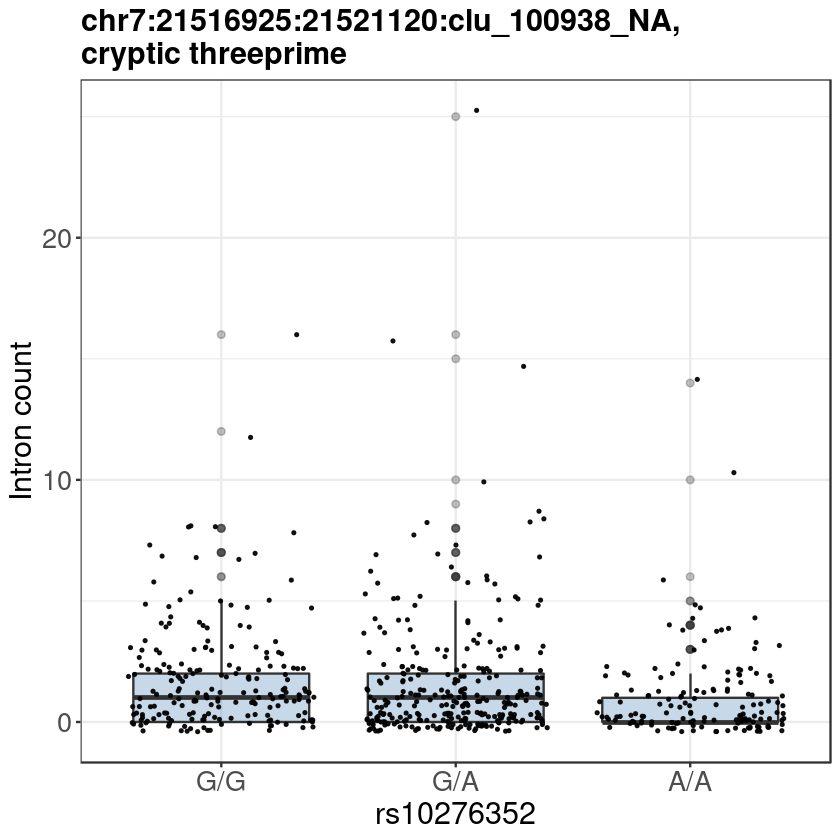

In [70]:
ggplot(cryptic_3, aes(x = geno, y = count)) +
    geom_boxplot(fill = "steelblue", alpha = 0.3) +
    geom_jitter(color = "black", size = 0.4, alpha = 0.9) +
    labs(x = "rs10276352", y = "Intron count", title = "chr7:21516925:21521120:clu_100938_NA,\ncryptic threeprime") +
    theme_bw() +
    theme(plot.title = element_text(size = 18, face = "bold"),
          axis.text = element_text(size = 16),
          axis.title = element_text(size = 18))

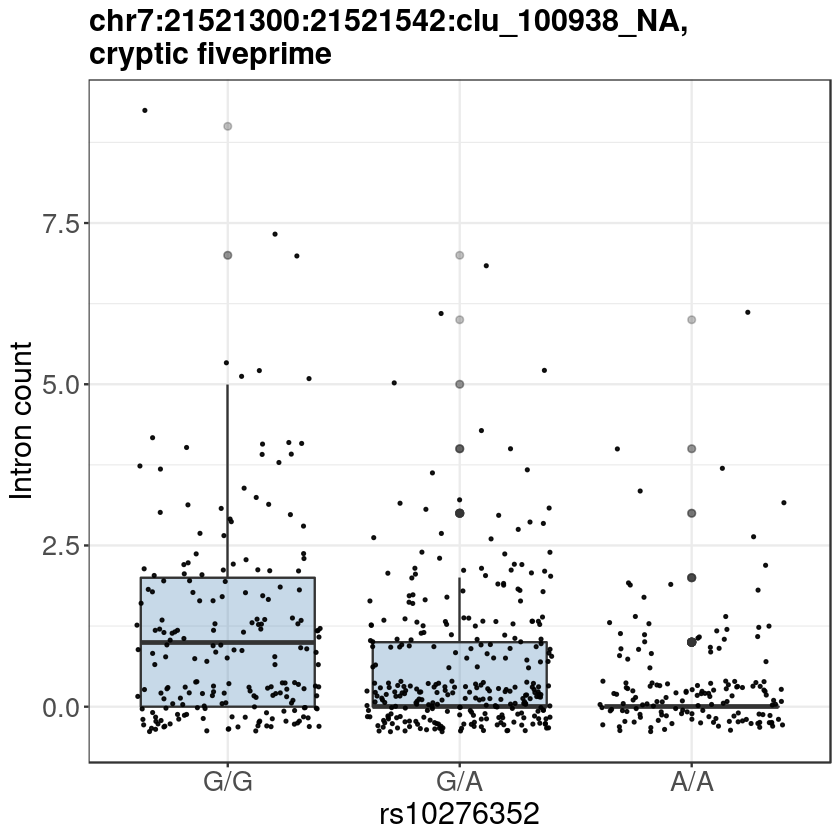

In [66]:
cryptic_5 <- data.frame("count" = NA, "geno" = NA)
for (i in 1:640) {
    cryptic_5[i, "count"] <- clusters[3,i]
    cryptic_5[i, "geno"] <- vcf[2,i+9]
}
cryptic_5[cryptic_5 == "0/0"] <- "G/G"
cryptic_5[cryptic_5 == "0/1"] <- "G/A"
cryptic_5[cryptic_5 == "1/1"] <- "A/A"
cryptic_5$geno <- factor(cryptic_5$geno, levels = c("G/G", "G/A", "A/A"))

ggplot(cryptic_5, aes(x = geno, y = count)) +
    geom_boxplot(fill = "steelblue", alpha = 0.3) +
    geom_jitter(color = "black", size = 0.4, alpha = 0.9) +
    labs(x = "rs10276352", y = "Intron count", title = "chr7:21521300:21521542:clu_100938_NA,\ncryptic fiveprime") +
    theme_bw() +
    theme(plot.title = element_text(size = 18, face = "bold"),
          axis.text = element_text(size = 16),
          axis.title = element_text(size = 18))

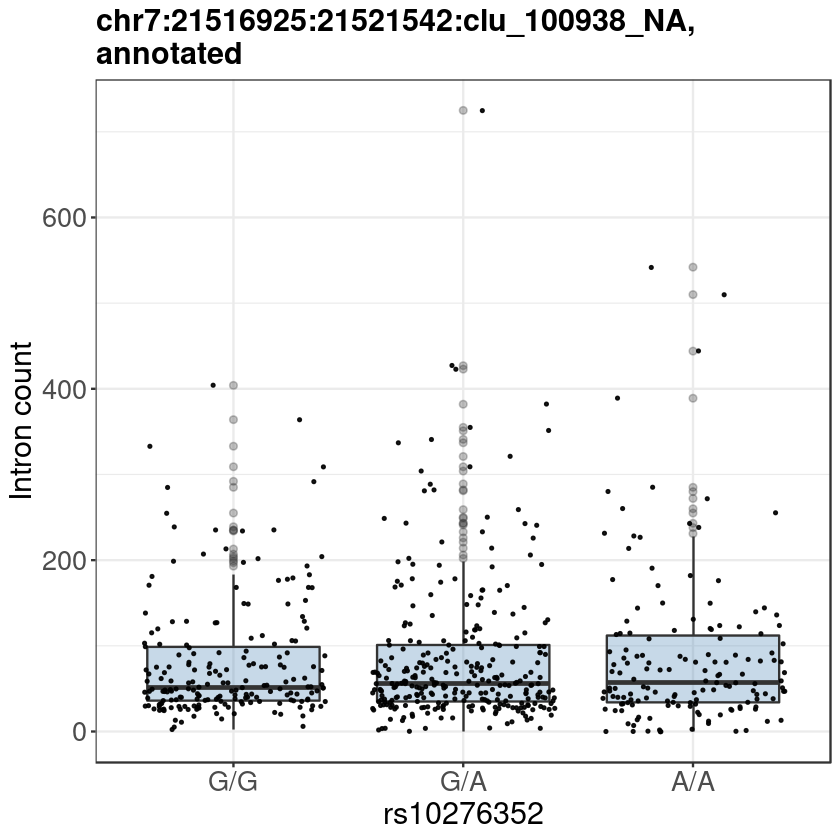

In [19]:
annotated <- data.frame("count" = NA, "geno" = NA)
for (i in 1:640) {
    annotated[i, "count"] <- clusters[2,i]
    annotated[i, "geno"] <- vcf[2,i+9]
}
annotated[annotated == "0/0"] <- "G/G"
annotated[annotated == "0/1"] <- "G/A"
annotated[annotated == "1/1"] <- "A/A"
annotated$geno <- factor(annotated$geno, levels = c("G/G", "G/A", "A/A"))
ggplot(annotated, aes(x = geno, y = count)) +
    geom_boxplot(fill = "steelblue", alpha = 0.3) +
    geom_jitter(color = "black", size = 0.4, alpha = 0.9) +
    labs(x = "rs10276352", y = "Intron count", title = "chr7:21516925:21521542:clu_100938_NA,\nannotated") +
    theme_bw() +
    theme(plot.title = element_text(size = 18, face = "bold"),
          axis.text = element_text(size = 16),
          axis.title = element_text(size = 18))

In [20]:
clusters.t <- t(clusters)

In [21]:
clusters.t <- as.data.frame(clusters.t)

In [22]:
clusters.t <- clusters.t %>% mutate(prop = `chr7:21516925:21521542:clu_100938_NA` / (`chr7:21516925:21521120:clu_100938_NA` + `chr7:21516925:21521542:clu_100938_NA` + `chr7:21521300:21521542:clu_100938_NA`))

In [24]:
clusters.t <- cbind(clusters.t, annotated)

In [25]:
table(clusters.t$geno)


G/G G/A A/A 
198 292 150 

In [26]:
library(ggbeeswarm)

Warning message:
“Removed 7 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 7 rows containing missing values (position_quasirandom).”


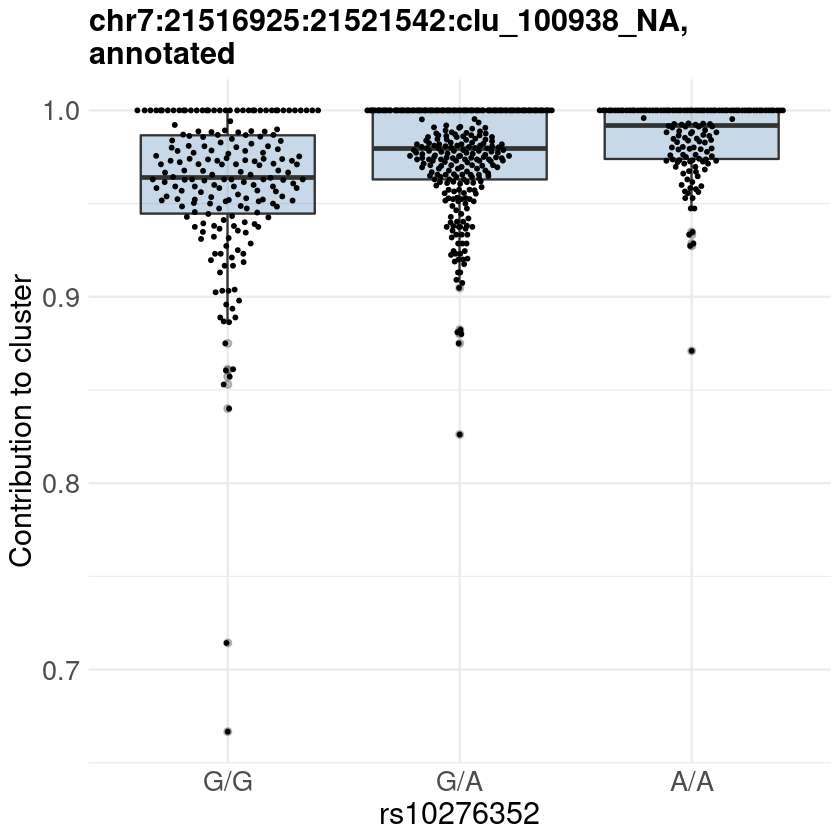

In [29]:
ggplot(clusters.t, aes(x = geno, y = prop)) +
    geom_boxplot(fill = "steelblue", alpha = 0.3) +
#     geom_jitter(color = "black", size = 0.4, alpha = 0.9) +
    geom_quasirandom(size = 0.6) +
    labs(x = "rs10276352", y = "Contribution to cluster", title = "chr7:21516925:21521542:clu_100938_NA,\nannotated") +
    theme_minimal() +
    theme(plot.title = element_text(size = 18, face = "bold"),
          axis.text = element_text(size = 16),
          axis.title = element_text(size = 18))

In [30]:
ggsave("../figures/sp4_intron.pdf", height = 6, width = 6)

Warning message:
“Removed 7 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 7 rows containing missing values (position_quasirandom).”
